In [2]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from fashion_model import FashionCNN 
from manifold_torch import Manifold_Image_Sampler

from captum.attr import Lime
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso, SkLearnLinearModel
from captum.attr._core.lime import get_exp_kernel_similarity_function

from custom_captume_lime import LimeBase

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EXPERIMENT = 'fashion_mnist'
RADIUS = 0.00001
NUM_PERTURBATIONS = 100
MULTIPLIER = 100
DIM = 3
PIVOTS = 10
SHUFFLE = False
TARGET = None

print("EXPERIMENT: ", EXPERIMENT)
print("RADIUS: ", RADIUS)
print("TARGET: ", TARGET)
print("DIM: ", DIM)
print("PIVOTS: ", PIVOTS)
print("SHUFFLE: ", SHUFFLE)

EXPERIMENT:  fashion_mnist
RADIUS:  1e-05
TARGET:  None
DIM:  3
PIVOTS:  10
SHUFFLE:  False


In [3]:
if EXPERIMENT == 'fashion_mnist':
    print("Loading fashion mnist")
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    print("Loading mnist")
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))
no_samples, channels, rows, cols = all_images.shape

Loading fashion mnist
Done loading


In [4]:
# checkpt_file = 'pretrained/mnistCNN.pt'
checkpt_file = 'pretrained/fashionCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/fashionCNN.pt


<All keys matched successfully>

In [5]:
start_time = time.time()
manifold_sampler = Manifold_Image_Sampler(all_images, dim = DIM, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)

if TARGET == None:
    targets = None
    target_str = 'all'
else:
    targets = [TARGET]
    target_str = str(TARGET)

# Get the hyperplanes
_ = manifold_sampler.get_pivots(manifold_sampler.labels, MULTIPLIER, shuffle = SHUFFLE, target_labels=targets)
manifold_G = manifold_sampler.get_G_from_pivots()
Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)

Initialize duration:  238.51112461090088


<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 

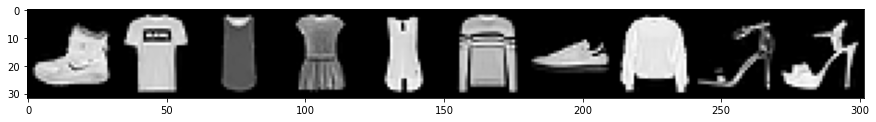

In [6]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(label.item(), end=", ")

Predictions:  7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 

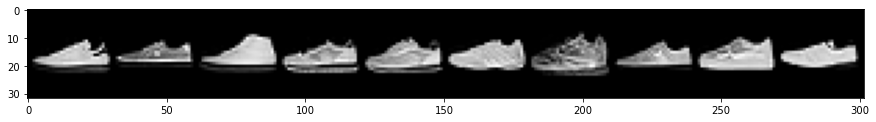

In [7]:
demo_start = 700
demo_images = manifold_sampler.pivots[demo_start:demo_start + 10]

grid = torchvision.utils.make_grid(demo_images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

demo_pred = model(demo_images.to(device))
demo_pred_label = [l[0] for l in list(torch.topk(demo_pred, 1)[1].cpu().detach().numpy())]

print("Predictions: ", end=" ")
for l in enumerate(demo_pred_label):
    print(l[1], end=", ")

In [8]:
from sklearn import linear_model

sigma = 10
sim_sigma = 4

def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

def view_10(model_, inputs_, offset_ = 0, view_pred = False):
    demo_start = offset_
    demo_images = inputs_[demo_start:demo_start + 10]
    img_min = torch.min(demo_images)
    demo_images = demo_images - torch.min(demo_images)
    demo_images = demo_images/torch.max(demo_images)

    grid = torchvision.utils.make_grid(demo_images, nrow=10)
    plt.figure(figsize=(15, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    
    if view_pred == True:
        demo_pred = model_(demo_images.float().to(device))
        demo_pred_label = [l[0] for l in list(torch.topk(demo_pred, 1)[1].cpu().detach().numpy())]

        print("Predictions: ", end=" ")
        for l in enumerate(demo_pred_label):
            print(l[1], end=", ")

In [9]:
DUPLICATIONS = 10
RADIUS = 100.0
base_RADIUS = 0.0
base_images = []
perturbations = []
gauss_perturb = []
for _ in range(DUPLICATIONS):
    # base
    base_gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    r = np.random.uniform()*base_RADIUS
    base_gauss_norm = normalize(base_gauss_, r)
    base_pc = manifold_sampler.to_1d(manifold_sampler.pivots + base_gauss_norm)
    
    # gauss
    gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    gauss_noise = manifold_sampler.to_1d(gauss_)
    plane_noise = np.zeros_like(gauss_noise)
    for d in range(Gv.shape[0]):
        proj = np.dot(gauss_noise, Gv[d])
        for s in range(plane_noise.shape[0]):
            plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
    ortho_noise = gauss_noise - plane_noise
    
    # noise
    r = np.random.uniform()*RADIUS
    ortho_norm = normalize(ortho_noise, r)
    gauss_norm = normalize(gauss_noise, r)
    ortho_pc = base_pc + ortho_norm
    gauss_pc = base_pc + gauss_norm
    base_images.append(manifold_sampler.to_3d(base_pc))
    perturbations.append(manifold_sampler.to_3d(ortho_pc))
    gauss_perturb.append(manifold_sampler.to_3d(gauss_pc))
    
base_images   = torch.cat(base_images)
perturbations = torch.cat(perturbations)
gauss_perturb = torch.cat(gauss_perturb)
base_embeded    = manifold_sampler.transform(base_images)
perturb_embeded = manifold_sampler.transform(perturbations)
gauss_embeded   = manifold_sampler.transform(gauss_perturb)

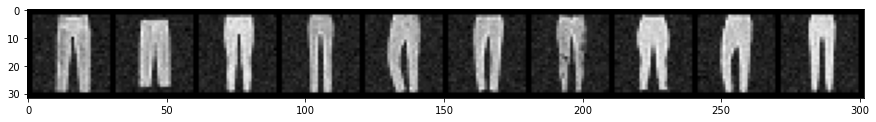

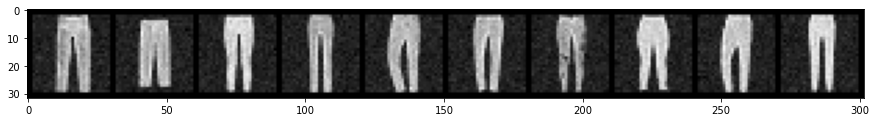

In [10]:
offset = 2100
view_10(model, perturbations, offset)
view_10(model, gauss_perturb, offset)

In [11]:
def plot_forplots(base_img, list_of_imgs, label = 0):
    max_val = np.max(np.asarray([np.max(x) for x in list_of_imgs]))
    min_val = np.min(np.asarray([np.min(x) for x in list_of_imgs]))
    mag_val = max([abs(max_val),abs(min_val)])
    size = 2
    cols = len(list_of_imgs)
    figure, axes = plt.subplots(nrows=1, ncols=1+cols, figsize=(size*(cols),size))
    axes.ravel()[0].imshow(base_img, cmap=plt.get_cmap('Greys'))
    axes.ravel()[0].set_axis_off()
    for a in range(cols):
        img = list_of_imgs[a]
        axes.ravel()[a+1].imshow(img, cmap=plt.get_cmap('coolwarm'),
                                vmin=-mag_val, vmax=mag_val)
        axes.ravel()[a+1].set_axis_off()
    plt.tight_layout()
#     plt.savefig("mnist_viz/mnist_" + str(label) + ".jpg")

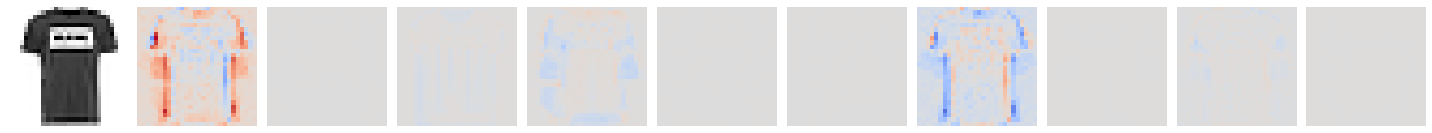

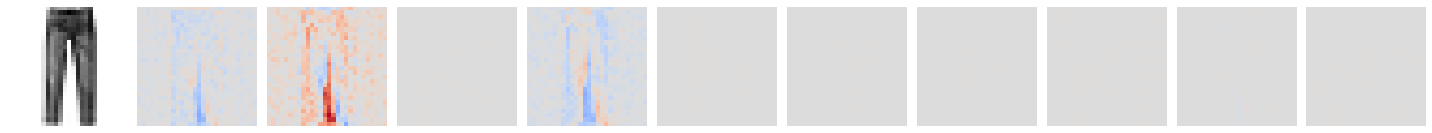

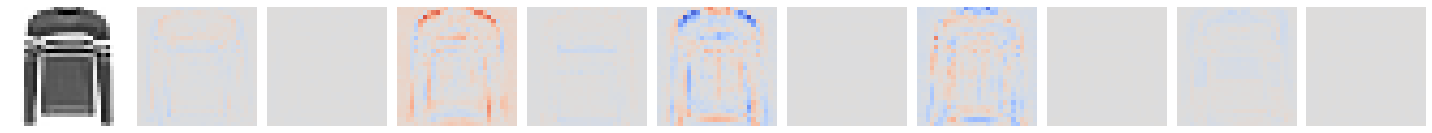

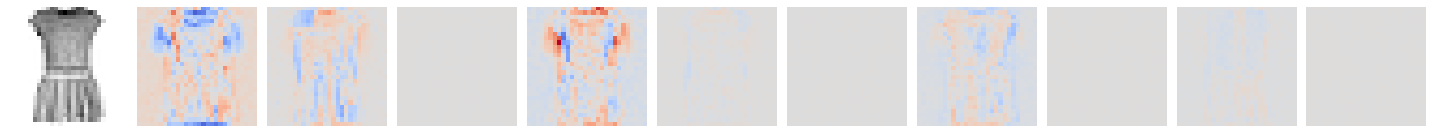

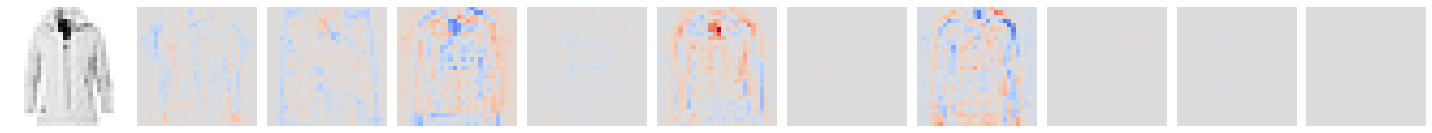

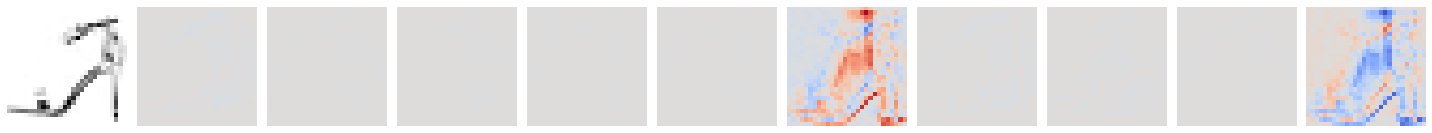

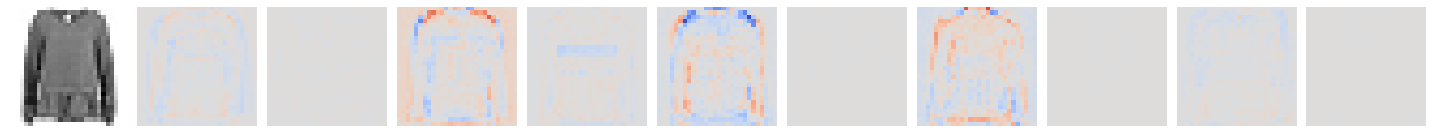

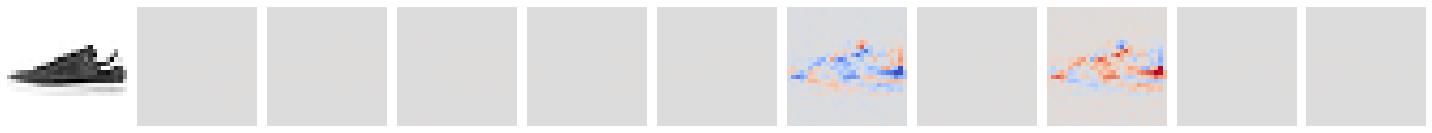

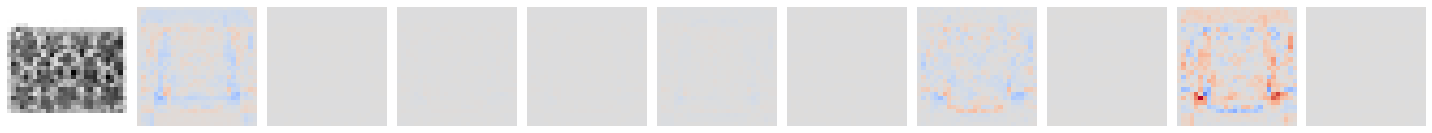

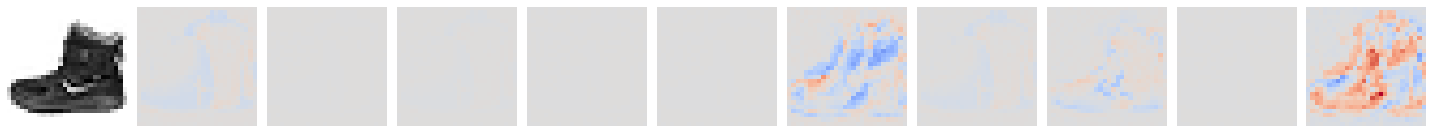

In [12]:
for index_to_explain in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:
    image_to_explain = manifold_sampler.pivots[index_to_explain]

    perturb_outputs = model(perturbations.float().to(device))
    probs = nn.functional.softmax(perturb_outputs, dim = 1)

    base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
    similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

    repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
    repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
    true_perturb = perturbations - repeat_image_to_explain

    clf = linear_model.Ridge(alpha = 200)
    image_to_explain_np = image_to_explain[0].cpu().detach().numpy()
    forplots = []
    for out in range(probs.shape[1]):
        perturb_pred = probs[:,out].cpu().detach().numpy()
        clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_pred, sample_weight=similarities)
        explanation = clf.coef_.reshape(rows, cols)
        forplots.append(-explanation)

    plot_forplots(image_to_explain_np, forplots, index_to_explain)

In [13]:
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum.metrics._core.infidelity import infidelity
from captum.metrics._core.sensitivity import sensitivity_max


from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import KernelShap
from captum.attr import DeepLift

In [14]:
sigma = 10
sim_sigma = 4

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float().to(device)
    return noise, inputs - noise

exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=sim_sigma)

lime_zero = Lime(model, 
                interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
                similarity_func=exp_eucl_distance)

def to_interp_transform(curr_sample, original_inp,
                                      **kwargs):
     return curr_sample.to(device)
    
def similarity_kernel_lime(
    original_input,
    perturbed_input,
    perturbed_interpretable_input,
    **kwargs):
        # kernel_width will be provided to attribute as a kwarg
        kernel_width = kwargs["kernel_width"]
        l2_dist = torch.norm(original_input - perturbed_input)
        return torch.exp(- (l2_dist**2) / (kernel_width**2))

def perturb_func_random_additive(
     original_input,
     **kwargs):
         return torch.abs(original_input.to(device) +  torch.rand_like(original_input.to(device)).to(device))
    
lime_random_add = LimeBase(model.to(device),
                         SkLearnLinearModel("linear_model.Ridge"),
                         similarity_func=similarity_kernel_lime,
                         perturb_func=perturb_func_random_additive,
                         perturb_interpretable_space=False,
                         from_interp_rep_transform=None,
                         to_interp_rep_transform=to_interp_transform)

def perturb_func_random_mul(
     original_input,
     **kwargs):
         return torch.abs(original_input.to(device) *  torch.randn_like(original_input.to(device)).to(device))
    
lime_random_mul = LimeBase(model.to(device),
                         SkLearnLinearModel("linear_model.Ridge"),
                         similarity_func=similarity_kernel_lime,
                         perturb_func=perturb_func_random_mul,
                         perturb_interpretable_space=False,
                         from_interp_rep_transform=None,
                         to_interp_rep_transform=to_interp_transform)

shap_ex = KernelShap(model)
deep_ex = DeepLift(model)
gras_ex = GradientShap(model)

In [15]:
index_to_explain = 601
image_to_explain = image_to_explain = manifold_sampler.pivots[index_to_explain]
original_output = model(image_to_explain.unsqueeze(0).to(device))
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]

shap = shap_ex.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction
        )

deep = deep_ex.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction
        )

gras = gras_ex.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            baselines=torch.zeros_like(image_to_explain.unsqueeze(0)).to(device)
        )

lime_zero_exp = lime_zero.attribute(
        image_to_explain.unsqueeze(0).to(device),
        target=first_prediction,
        n_samples=1000,
        perturbations_per_eval=16,
        show_progress=False
    )

lime_rand_add = lime_random_add.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=1000,
            perturbations_per_eval=16,
            show_progress=False,
            kernel_width=1000
                ).reshape(1,1,rows, cols)

lime_rand_mul = lime_random_mul.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=1000,
            perturbations_per_eval=16,
            show_progress=False,
            kernel_width=1000
                ).reshape(1,1,rows, cols)

/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [19]:
titles = ["", "EMaP", "SHAP", "LIME zero", "LIME +" , "LIME *"]

def plot_forplots(base_img, list_of_imgs, label = 0, titles = None):
    size = 2
    cols = len(list_of_imgs)
    figure, axes = plt.subplots(nrows=1, ncols=1+cols, figsize=(size*(cols),size))
    axes.ravel()[0].imshow(base_img, cmap=plt.get_cmap('Greys'))
    axes.ravel()[0].set_axis_off()
    for a in range(cols):
        img = list_of_imgs[a]
        max_val = np.max(img)
        min_val = np.min(img)
        mag_val = max([abs(max_val),abs(min_val)])
        axes.ravel()[a+1].imshow(img, 
                                 cmap=plt.get_cmap('coolwarm'),
#                                  map=plt.get_cmap('grey'),
                                vmin=-mag_val, vmax=mag_val
                                )
        if titles != None:
            axes.ravel()[a+1].title.set_text(titles[a+1])
        axes.ravel()[a+1].set_axis_off()
        
    plt.tight_layout()
    plt.savefig("result/images/fashion_" + str(label) + ".jpg")

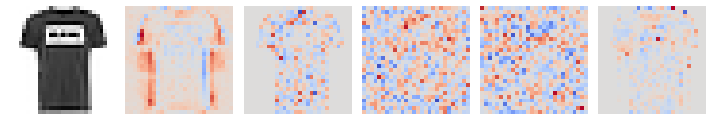

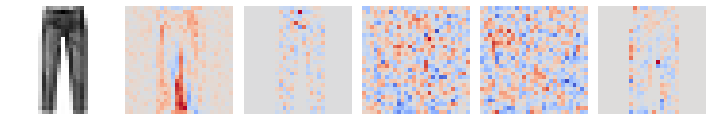

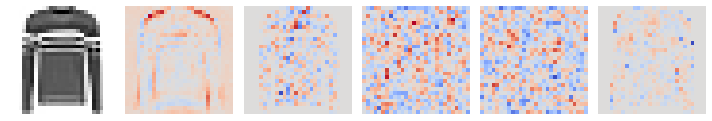

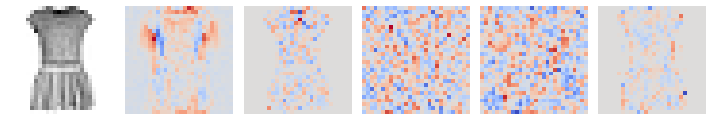

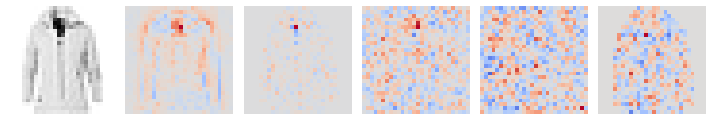

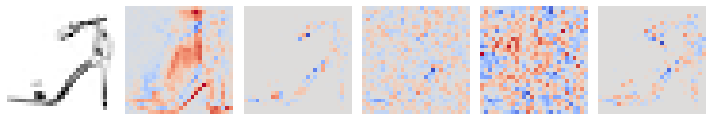

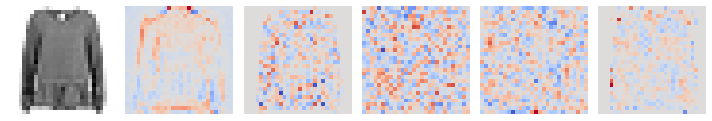

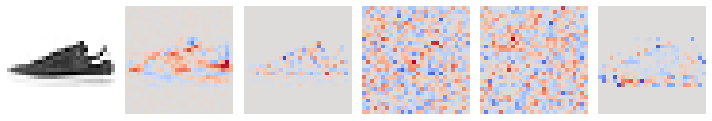

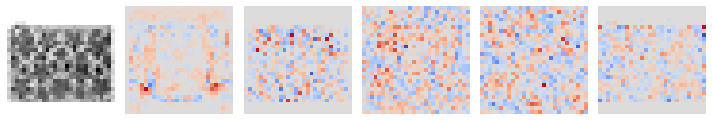

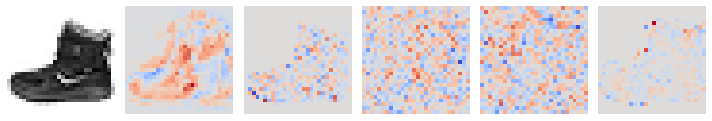

In [20]:
for index_to_explain in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:
    forplots = []
    image_to_explain = manifold_sampler.pivots[index_to_explain]

    perturb_outputs = model(perturbations.float().to(device))
    probs = nn.functional.softmax(perturb_outputs, dim = 1)

    base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
    similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

    repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
    repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
    true_perturb = perturbations - repeat_image_to_explain

    clf = linear_model.Ridge(alpha = 200)
    image_to_explain_np = image_to_explain[0].cpu().detach().numpy()
    
    out = torch.tensor(index_to_explain/100).int()
    perturb_pred = probs[:,out].cpu().detach().numpy()
    clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_pred, sample_weight=similarities)
    emap_explanation = -clf.coef_.reshape(rows, cols)
#     plt.figure()
#     plt.imshow(-emap_explanation)
    forplots.append(emap_explanation)
    
    gras = gras_ex.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            baselines=torch.zeros_like(image_to_explain.unsqueeze(0)).to(device)
        ).reshape(rows, cols).cpu().detach().numpy()

    lime_zero_exp = lime_zero.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=1000,
            perturbations_per_eval=16,
            show_progress=False
        ).reshape(rows, cols).cpu().detach().numpy()

    lime_rand_add = lime_random_add.attribute(
                image_to_explain.unsqueeze(0).to(device),
                target=first_prediction,
                n_samples=1000,
                perturbations_per_eval=16,
                show_progress=False,
                kernel_width=1000
                    ).reshape(rows, cols).cpu().detach().numpy()

    lime_rand_mul = lime_random_mul.attribute(
                image_to_explain.unsqueeze(0).to(device),
                target=first_prediction,
                n_samples=1000,
                perturbations_per_eval=16,
                show_progress=False,
                kernel_width=1000
                    ).reshape(rows, cols).cpu().detach().numpy()
    
    forplots.append(gras)
    forplots.append(lime_zero_exp)
    forplots.append(lime_rand_add)
    forplots.append(lime_rand_mul)
    
    plot_forplots(image_to_explain_np, forplots, index_to_explain)

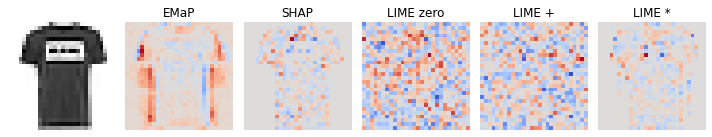

In [21]:
for index_to_explain in [0]:
    forplots = []
    image_to_explain = manifold_sampler.pivots[index_to_explain]

    perturb_outputs = model(perturbations.float().to(device))
    probs = nn.functional.softmax(perturb_outputs, dim = 1)

    base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
    similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

    repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
    repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
    true_perturb = perturbations - repeat_image_to_explain

    clf = linear_model.Ridge(alpha = 200)
    image_to_explain_np = image_to_explain[0].cpu().detach().numpy()
    
    out = torch.tensor(index_to_explain/100).int()
    perturb_pred = probs[:,out].cpu().detach().numpy()
    clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_pred, sample_weight=similarities)
    emap_explanation = -clf.coef_.reshape(rows, cols)
#     plt.figure()
#     plt.imshow(-emap_explanation)
    forplots.append(emap_explanation)
    
    gras = gras_ex.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            baselines=torch.zeros_like(image_to_explain.unsqueeze(0)).to(device)
        ).reshape(rows, cols).cpu().detach().numpy()

    lime_zero_exp = lime_zero.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=1000,
            perturbations_per_eval=16,
            show_progress=False
        ).reshape(rows, cols).cpu().detach().numpy()

    lime_rand_add = lime_random_add.attribute(
                image_to_explain.unsqueeze(0).to(device),
                target=first_prediction,
                n_samples=1000,
                perturbations_per_eval=16,
                show_progress=False,
                kernel_width=1000
                    ).reshape(rows, cols).cpu().detach().numpy()

    lime_rand_mul = lime_random_mul.attribute(
                image_to_explain.unsqueeze(0).to(device),
                target=first_prediction,
                n_samples=1000,
                perturbations_per_eval=16,
                show_progress=False,
                kernel_width=1000
                    ).reshape(rows, cols).cpu().detach().numpy()
    
    forplots.append(gras)
    forplots.append(lime_zero_exp)
    forplots.append(lime_rand_add)
    forplots.append(lime_rand_mul)
    
    plot_forplots(image_to_explain_np, forplots, index_to_explain, titles = titles)

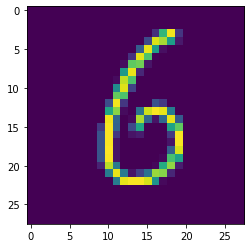

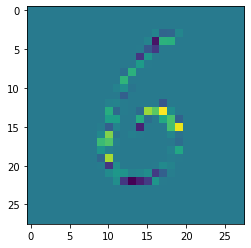

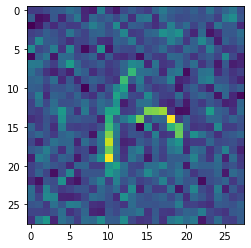

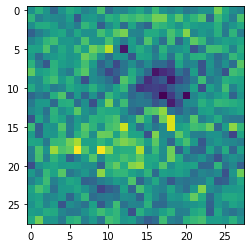

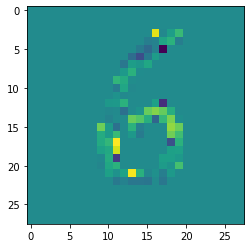

In [25]:
plt.figure()
plt.imshow(image_to_explain.detach().cpu()[0])
# plt.figure()
# plt.imshow(shap.detach().cpu()[0,0])
# plt.figure()
# plt.imshow(deep.detach().cpu()[0,0])
plt.figure()
plt.imshow(gras.detach().cpu()[0,0])
plt.figure()
plt.imshow(lime_zero.detach().cpu()[0,0])
plt.figure()
plt.imshow(lime_rand_add.detach().cpu()[0,0])
plt.figure()
plt.imshow(lime_rand_mul.detach().cpu()[0,0])

In [5]:
sigma = 10
sim_sigma = 4

def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float().to(device)
    return noise, inputs - noise

exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=sim_sigma)


lr_lime = Lime(model, 
              interpretable_model=SkLearnLinearRegression(), 
              similarity_func=exp_eucl_distance,
              perturb_func = None)



In [6]:
index_to_explain = 600
image_to_explain = all_images[index_to_explain]

original_output = model(image_to_explain.unsqueeze(0).to(device))

first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
# perturb_1st = probs[:,first_prediction.item()].cpu().detach().numpy()
# perturb_2nd = probs[:,second_prediction.item()].cpu().detach().numpy()

lime_1st = lr_lime.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=200,
            perturbations_per_eval=16,
            show_progress=False
        )

In [7]:
lime_np = lime_1st.squeeze(0).cpu().detach().numpy()[0]

In [10]:
torch.tensor(lime_np).to(device).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [8]:
image_to_explain.shape

torch.Size([1, 28, 28])

In [7]:
infid_1st = infidelity(model.to(device), perturb_fn, image_to_explain.unsqueeze(0).to(device), lime_1st.to(device), target=first_prediction)
print(infid_1st)

tensor([0.4274], device='cuda:0')


In [93]:
torch.max(torch.randn_like(image_to_explain))

tensor(3.4569)

In [8]:
from captum._utils.models.linear_model import SkLearnLinearModel

def perturb_func_base(
     original_input,
     **kwargs):
         return original_input.to(device) +  torch.rand_like(original_input.to(device)).to(device) 

def to_interp_transform(curr_sample, original_inp,
                                      **kwargs):
     return curr_sample.to(device)
    
def similarity_kernel(
    original_input,
    perturbed_input,
    perturbed_interpretable_input,
    **kwargs):
        # kernel_width will be provided to attribute as a kwarg
        kernel_width = kwargs["kernel_width"]
        l2_dist = torch.norm(original_input - perturbed_input)
        return torch.exp(- (l2_dist**2) / (kernel_width**2))
    
lime_attr = LimeBase(model.to(device),
                         SkLearnLinearModel("linear_model.Ridge"),
                         similarity_func=similarity_kernel,
                         perturb_func=perturb_func_base,
                         perturb_interpretable_space=False,
                         from_interp_rep_transform=None,
                         to_interp_rep_transform=to_interp_transform)

In [9]:
lime_rand = lime_attr.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=2000,
            perturbations_per_eval=16,
            show_progress=False,
            kernel_width=1000
                ).reshape(1,1,rows, cols)

torch.Size([2000, 784])
torch.Size([2000])
torch.Size([2000])


In [10]:
infid_rand = infidelity(model.to(device), perturb_fn, image_to_explain.unsqueeze(0).to(device), lime_rand.to(device), target=first_prediction)
print(infid_rand)

tensor([12.4137], device='cuda:0')


In [11]:
def binarize_tensor(tensor, number_of_ones):
    binary_tensor = torch.zeros_like(tensor.reshape(rows*cols))
    _, top_indices = torch.topk(tensor.reshape(rows*cols), number_of_ones, sorted=False)
    binary_tensor[top_indices] = 1

    return binary_tensor.reshape(1,1,rows,cols)

In [86]:
def rdt_fidelity(model, inp, exp, target, samples = 100, num_ones = 10):
    correct = 0.0
    
    mask = binarize_tensor(exp, num_ones)
    
    for i in range(samples):
        perturb = mask * inp + (1 - mask) * torch.rand_like(inp)*0.2
        log_logits = model(perturb)
        distorted_labels = log_logits.argmax(dim=-1)
        if distorted_labels == target:
            correct += 1
    return correct / samples

    

In [90]:
rdt_fidelity(model.to(device), image_to_explain.unsqueeze(0).to(device), lime_rand.to(device),  target=first_prediction, samples = 100, num_ones = 50)

0.02

In [73]:
mask = binarize_tensor(lime_rand.to(device), 80)

In [80]:
perturb = mask * image_to_explain.unsqueeze(0).to(device) + (1 - mask) * torch.rand_like(image_to_explain.unsqueeze(0).to(device))*0.1

In [81]:
perturb.shape

torch.Size([1, 1, 28, 28])

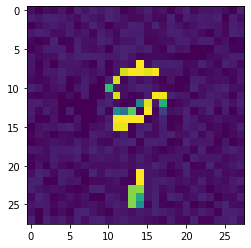

In [82]:
plt.figure()
plt.imshow(perturb.detach().cpu()[0,0])

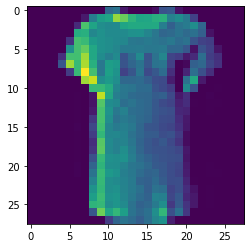

In [9]:

plt.figure()
plt.imshow(image_to_explain[0])
# plt.figure()
# plt.imshow(lime_1st.detach().cpu()[0,0])
# plt.figure()
# plt.imshow(lime_rand.detach().cpu()[0,0])

In [ ]:
>>> # Define similarity kernel (exponential kernel based on L2 norm)
>>> def similarity_kernel(
>>>     original_input: Tensor,
>>>     perturbed_input: Tensor,
>>>     perturbed_interpretable_input: Tensor,
>>>     **kwargs)->Tensor:
>>>         # kernel_width will be provided to attribute as a kwarg
>>>         kernel_width = kwargs["kernel_width"]
>>>         l2_dist = torch.norm(original_input - perturbed_input)
>>>         return torch.exp(- (l2_dist**2) / (kernel_width**2))
>>>
>>>
>>> # Define sampling function
>>> # This function samples in original input space
>>> def perturb_func(
>>>     original_input: Tensor,
>>>     **kwargs)->Tensor:
>>>         return original_input + torch.randn_like(original_input)
>>>
>>> # For this example, we are setting the interpretable input to
>>> # match the model input, so the to_interp_rep_transform
>>> # function simply returns the input. In most cases, the interpretable
>>> # input will be different and may have a smaller feature set, so
>>> # an appropriate transformation function should be provided.
>>>
>>> def to_interp_transform(curr_sample, original_inp,
>>>                                      **kwargs):
>>>     return curr_sample
>>>
>>> # Generating random input with size 1 x 5
>>> input = torch.randn(1, 5)
>>> # Defining LimeBase interpreter
>>> lime_attr = LimeBase(net,
                         SkLearnLinearModel("linear_model.Ridge"),
                         similarity_func=similarity_kernel,
                         perturb_func=perturb_func,
                         perturb_interpretable_space=False,
                         from_interp_rep_transform=None,
                         to_interp_rep_transform=to_interp_transform)
>>> # Computes interpretable model, returning coefficients of linear
>>> # model.
>>> attr_coefs = lime_attr.attribute(input, target=1, kernel_width=1.1)

In [8]:
from sklearn import linear_model

# n_samples = 100
sigma = 10
sim_sigma = 4

def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

In [9]:
DUPLICATIONS = 10
RADIUS = 0.00001
base_RADIUS = 0.0
perturbations = []
for _ in range(DUPLICATIONS):
    # base
    base_gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    r = np.random.uniform()*base_RADIUS
    base_gauss_norm = normalize(base_gauss_, r)
    base_pc = manifold_sampler.to_1d(manifold_sampler.pivots + base_gauss_norm)
    
    # gauss
    gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    gauss_noise = manifold_sampler.to_1d(gauss_)
    plane_noise = np.zeros_like(gauss_noise)
    for d in range(Gv.shape[0]):
        proj = np.dot(gauss_noise, Gv[d])
        for s in range(plane_noise.shape[0]):
            plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
    ortho_noise = gauss_noise - plane_noise
    
    # noise
    r = np.random.uniform()*RADIUS
    ortho_norm = normalize(ortho_noise, r)
    ortho_pc = base_pc + ortho_norm
    
    perturbations.append(manifold_sampler.to_3d(ortho_pc))
    
perturbations = torch.cat(perturbations)    
perturb_embeded = manifold_sampler.transform(perturbations)

In [10]:
# first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
# probs[:,second_prediction.item()].cpu().detach().numpy()
# probs[:,first_prediction.item()].cpu().detach().numpy()

In [11]:
no_samples, channels, rows, cols = all_images.shape

perturb_outputs = model(perturbations.float().to(device))
probs = nn.functional.softmax(perturb_outputs, dim = 1)

In [12]:
index_to_explain = 600
image_to_explain = manifold_sampler.pivots[index_to_explain]

original_output = model(image_to_explain.unsqueeze(0).to(device))
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
perturb_1st = probs[:,first_prediction.item()].cpu().detach().numpy()
perturb_2nd = probs[:,second_prediction.item()].cpu().detach().numpy()

In [13]:
base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

In [14]:
repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
true_perturb = perturbations - repeat_image_to_explain

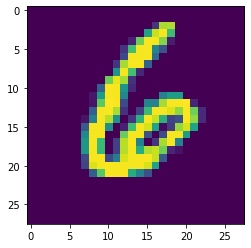

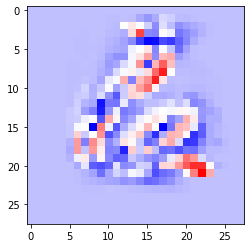

In [15]:
clf = linear_model.Ridge(alpha = 200)
clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_1st, sample_weight=similarities)
explanation_1st = clf.coef_.reshape(rows, cols)
# clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_2nd, sample_weight=similarities)
# explanation_2nd = -clf.coef_.reshape(rows, cols)

plt.figure()
plt.imshow(image_to_explain[0])
plt.figure()
plt.imshow(-explanation_1st, cmap=plt.get_cmap('bwr'))

# plt.figure()
# plt.imshow(explanation_2nd, cmap=plt.get_cmap('seismic'))

In [16]:
# explanation_diff = explanation_1st - explanation_2nd

# plt.figure()
# plt.imshow(explanation_diff, cmap=plt.get_cmap('seismic'))

In [17]:
image_to_explain_grad = Variable(image_to_explain, requires_grad=True)
original_output = model(image_to_explain_grad.unsqueeze(0).to(device))
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
original_output[0,first_prediction].backward()
image_grad = image_to_explain_grad.grad
grad_sq = normalize(image_grad.detach().numpy()**2,1)[0]
expl_sq = explanation_1st**2
expl_np = normalize(expl_sq - np.min(expl_sq),1)
sensitivity_score = np.inner(grad_sq.reshape(28*28),expl_np.reshape(28*28))

In [18]:
first_prediction

tensor(6, device='cuda:0')

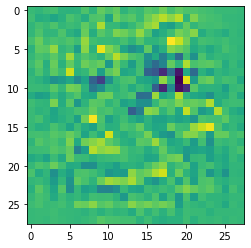

In [19]:
plt.imshow(image_grad[0])

In [20]:
sensitivity_score

0.2159513537021771

In [52]:
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum.metrics._core.infidelity import infidelity
from captum.metrics._core.sensitivity import sensitivity_max

In [44]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=sim_sigma)
lr_lime = Lime(model, 
              interpretable_model=SkLearnLinearRegression(), 
              similarity_func=exp_eucl_distance,
              perturb_func = None)

def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float().to(device)
    return noise, inputs - noise

In [40]:
lime_1st = lr_lime.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=200,
            perturbations_per_eval=16,
            show_progress=False
        )

In [48]:
infid = infidelity(model.to(device), perturb_fn, image_to_explain.unsqueeze(0).to(device), lime_1st.to(device), target=first_prediction)

In [68]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import Occlusion
from captum.attr import Lime
from captum.attr import DeepLiftShap
from captum.attr import visualization as viz

occlusion = Occlusion(model)

In [69]:
sens = sensitivity_max(explanation_func = Occlusion.attribute,
                    inputs = image_to_explain.unsqueeze(0).to(device),
                    target=first_prediction)

TypeError: attribute() missing 2 required positional arguments: 'inputs' and 'sliding_window_shapes'

In [33]:
def gen_mask(score, ones_ratio = 0.2):
    no_rows, no_cols = score.shape
    score_flat = np.reshape(score, no_rows*no_cols)
    top_k = int(ones_ratio*no_rows*no_cols)
    idx = np.argpartition(score_flat, -top_k)[-top_k:]
    indices = idx[np.argsort((-score_flat)[idx])]
    score_flat_dup = np.zeros_like(score_flat)
    score_flat_dup[indices] = 1.0
    score_dup = score_flat_dup.reshape(no_rows, no_cols)
    return score_dup

lime_1st = lr_lime.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=200,
            perturbations_per_eval=16,
            show_progress=False
        ).squeeze(0).cpu().detach().numpy()[0]

lime_2nd = lr_lime.attribute(
    image_to_explain.unsqueeze(0).to(device),
    target=second_prediction,
    n_samples=200,
    perturbations_per_eval=16,
    show_progress=False
).squeeze(0).cpu().detach().numpy()[0]

modified_image_lime = image_to_explain.clone().numpy()
modified_mask_lime = gen_mask(lime_1st - lime_2nd)
modified_image_lime[0][modified_mask_lime==1] = 1 - modified_image_lime[0][modified_mask_lime==1]
modified_image_lime = torch.tensor(modified_image_lime)
modified_output_lime = model(modified_image_lime.unsqueeze(0).to(device))
modified_prob_lime = nn.functional.softmax(modified_output_lime, dim = 1)

original_output = model(image_to_explain.unsqueeze(0).to(device))
original_prob = nn.functional.softmax(original_output, dim = 1)
original_log_odds = np.log(original_prob[0][first_prediction].cpu().detach().numpy()/original_prob[0][second_prediction].cpu().detach().numpy())
modified_log_odds_lime = np.log(modified_prob_lime[0][first_prediction].cpu().detach().numpy()/modified_prob_lime[0][second_prediction].cpu().detach().numpy())
log_odds_score_lime = original_log_odds - modified_log_odds_lime

RuntimeError: CUDA error: device-side assert triggered

In [19]:
print(log_odds_score_lime)

15.696755


In [41]:
lime_np = normalize(lime_1st**2 - np.min(lime_1st**2),1)
sensitivity_score_lime = np.inner(grad_sq.reshape(28*28),lime_np.reshape(28*28))

In [42]:
sensitivity_score_lime

0.18821463

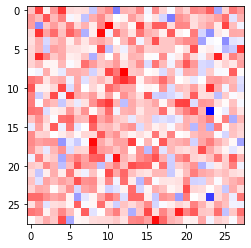

In [47]:
plt.imshow(lime_1st, cmap=plt.get_cmap('bwr'))

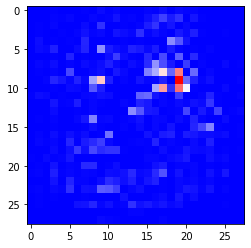

In [48]:
plt.imshow(grad_sq, cmap=plt.get_cmap('bwr'))
